The two code snippets (A and B) are quite similar in terms of their overall structure and purpose. Both aim to perform portfolio optimization and visualize the results, using different methods for generating the portfolios and constructing the efficient frontier. Let's highlight some of the key differences between these two code snippets:

Code A:

Imports the Seaborn library (import seaborn as sns) but doesn't seem to use it.
Defines a list of three stock symbols: stocks = ['AAPL', 'AMZN', 'GOOGL'].
Constructs plots for both stock prices and daily returns using a loop and the plt.plot() function.
Defines functions for calculating portfolio annualized performance and generating random portfolios.
The portfolio optimization is done through random portfolio generation, where portfolios are randomly constructed and evaluated for performance.
The display_simulated_ef_with_random() function plots the efficient frontier based on the simulated random portfolios.


Code B:

Imports only the necessary libraries without any unused imports.
Defines a list of five stock symbols: stocks = ['AAPL', 'AMZN', 'GOOGL', 'TSLA', 'MSFT'].
Defines functions for calculating portfolio return, portfolio volatility, portfolio annualized performance, and negative Sharpe ratio.
Uses specific optimization methods (minimize()) from the scipy.optimize module to find optimal portfolios based on different criteria.
The portfolio optimization includes finding the maximum Sharpe ratio portfolio and the minimum volatility portfolio.
Defines functions for efficient frontier calculations and displaying the calculated efficient frontier with random portfolios.
The display_calculated_ef_with_random() function plots the efficient frontier based on calculated efficient portfolios.
In summary, both code snippets achieve similar goals of portfolio optimization and efficient frontier visualization, but they differ in the methods they use for optimization, the number of stocks considered, and how they construct and evaluate portfolios. Code B seems to be more comprehensive in terms of optimization methods and portfolio evaluation functions, allowing for more flexibility and control over the optimization process.

# 1st - NOT using Efficient Frontier 

Generating random portfolios and analyzing their performance metrics, such as returns, volatility, and Sharpe ratio. It doesn't explicitly construct the Efficient Frontier curve --->



[*********************100%%**********************]  3 of 3 completed
--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.3
Annualized Volatility: 0.19


             AAPL   AMZN  GOOGL
allocation  55.54  44.41   0.05
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 0.22
Annualized Volatility: 0.16


            AAPL  AMZN  GOOGL
allocation  34.6  2.99  62.41


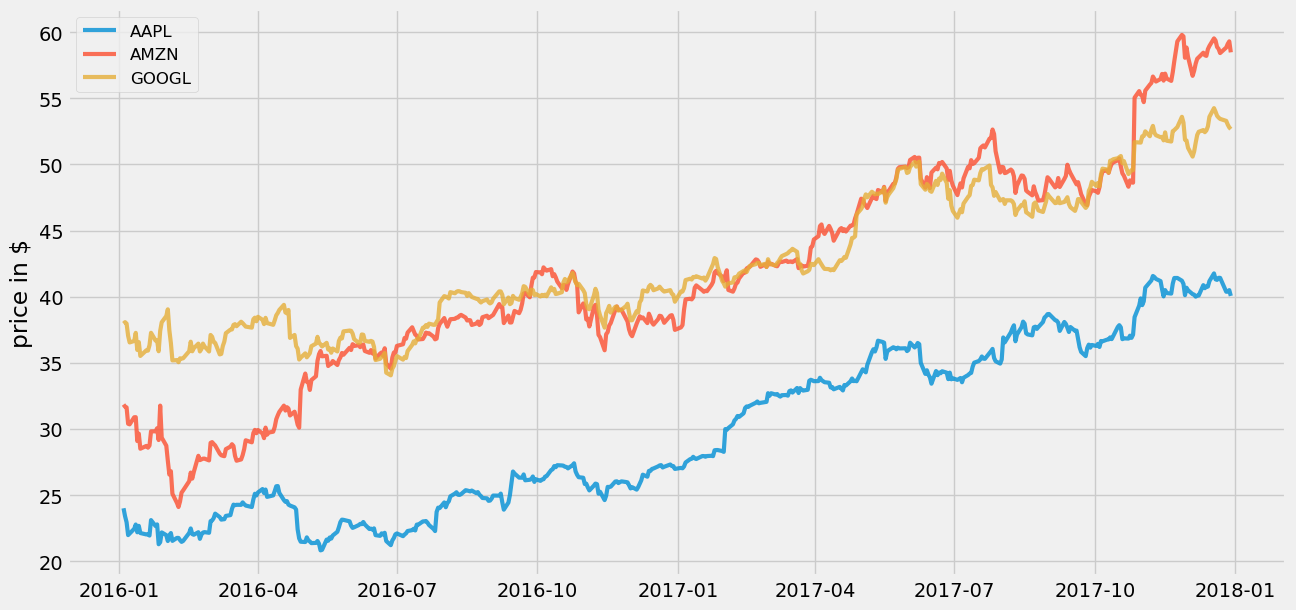

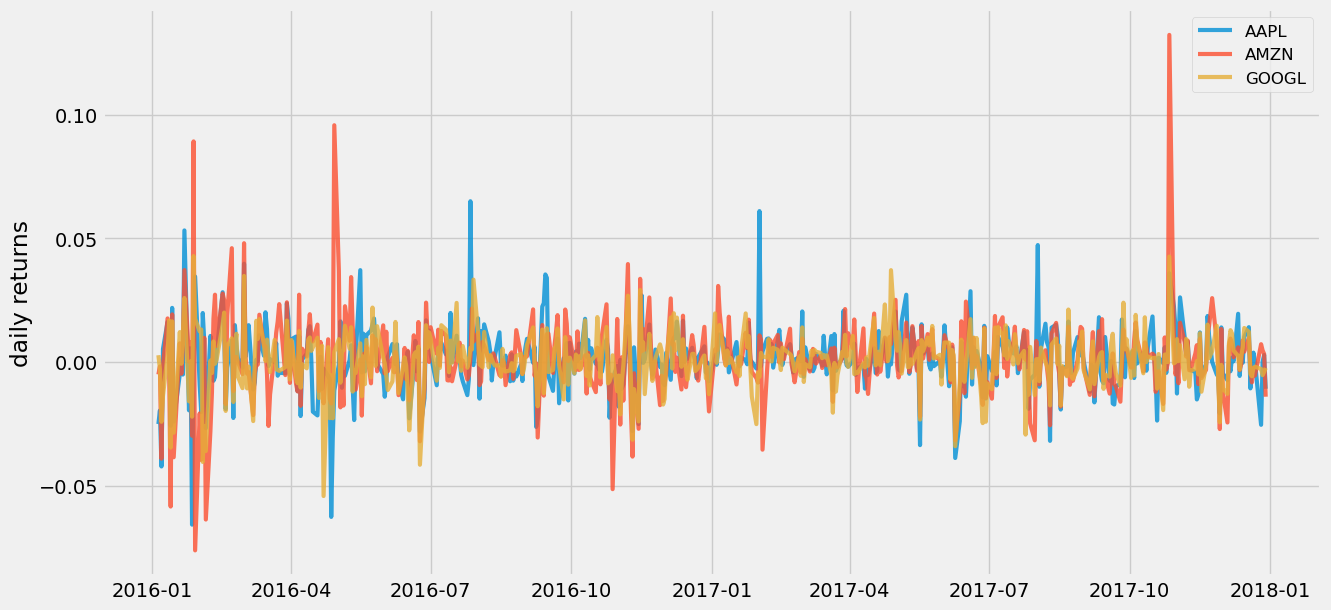

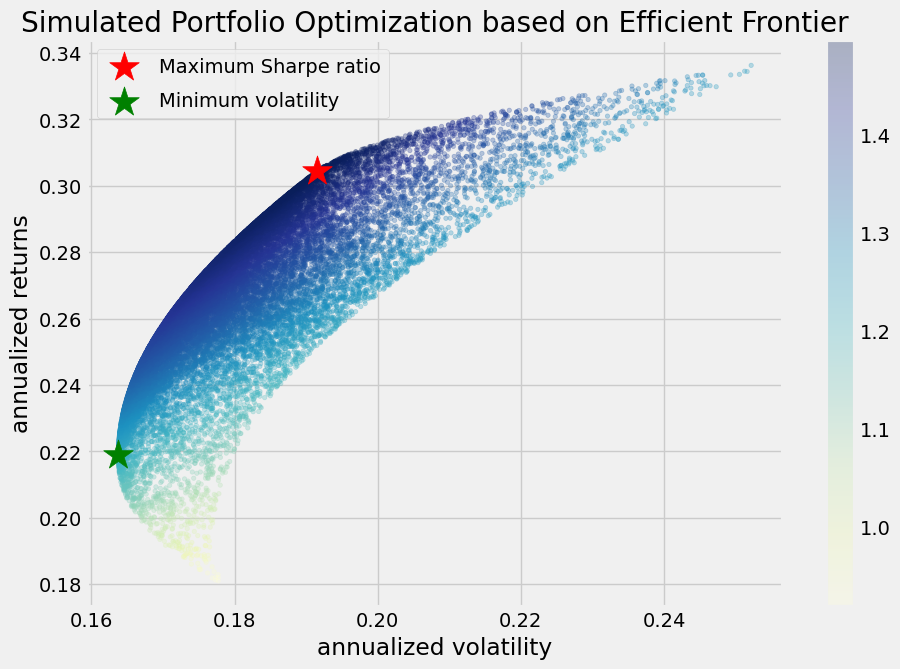

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

stocks = ['AAPL', 'AMZN', 'GOOGL']
start_date = '2016-01-01'
end_date = '2017-12-31'

data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

returns = data.pct_change()

plt.figure(figsize=(14, 7))
for c in data.columns.values:
    plt.plot(data.index, data[c], lw=3, alpha=0.8, label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8, label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):  # Change xrange to range (for Python 3 compatibility)
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        results[0, i] = portfolio_std_dev
        results[1, i] = portfolio_return
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record


mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=data.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i * 100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0, min_vol_idx], results[1, min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx], index=data.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i * 100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print("-" * 80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualized Return:", round(rp, 2))
    print("Annualized Volatility:", round(sdp, 2))
    print("\n")
    print(max_sharpe_allocation)
    print("-" * 80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualized Return:", round(rp_min, 2))
    print("Annualized Volatility:", round(sdp_min, 2))
    print("\n")
    print(min_vol_allocation)

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp, rp, marker='*', color='r', s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min, rp_min, marker='*', color='g', s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=0.8)

display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)


## 2: Finding the optimal portfolio allocation that maximizes the Sharpe ratio while adhering to certain constraints.

 It iterates through different target returns to construct the Efficient Frontier curve, showcasing the trade-off between portfolio return and portfolio volatility for different levels of risk.

[*********************100%%**********************]  5 of 5 completed
--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.0
Annualised Volatility: 0.02


            AAPL  AMZN  GOOGL  TSLA   MSFT
allocation   0.0   0.0    0.0   0.0  100.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.0
Annualised Volatility: 0.01


             AAPL  AMZN  GOOGL  TSLA  MSFT
allocation  30.64   0.0  34.26  29.5   5.6


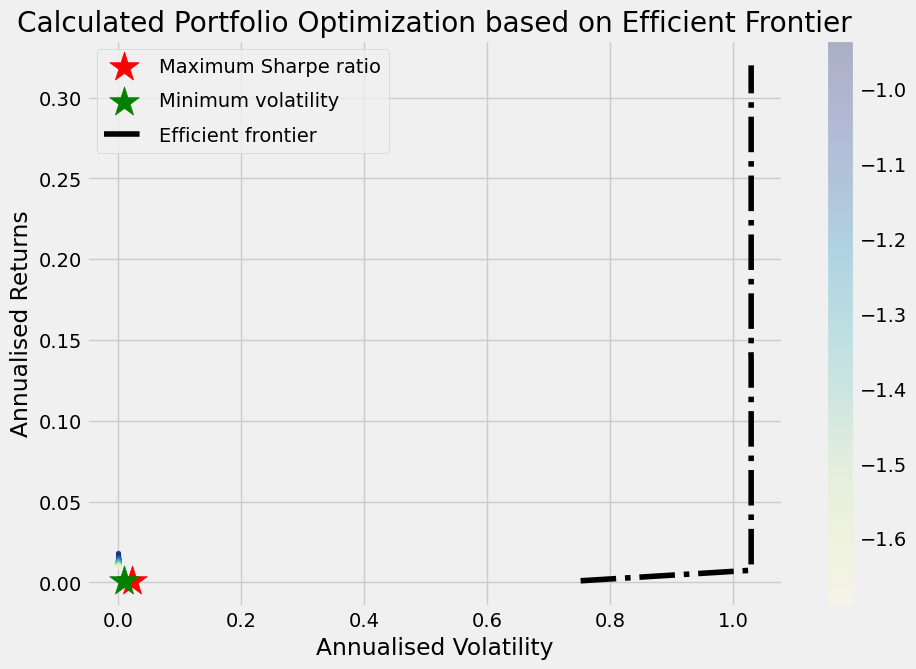

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

# Define stock symbols and date range
stocks = ['AAPL', 'AMZN', 'GOOGL', 'TSLA', 'MSFT']  # List of 5 random stocks
start_date = '2016-01-01'
end_date = '2017-12-31'

# Download stock data
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

returns = data.pct_change()

mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.0178

# Define portfolio functions
num_assets = len(stocks)

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_stddev
    return results, weights_record

def portfolio_return(weights, mean_returns):
    return np.sum(mean_returns * weights)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    p_return = portfolio_return(weights, mean_returns)
    p_volatility = portfolio_volatility(weights, cov_matrix)
    return p_volatility, p_return

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    args = (mean_returns, cov_matrix, risk_free_rate)

    def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate):
        p_return = portfolio_return(weights, mean_returns)
        p_volatility = portfolio_volatility(weights, cov_matrix)
        sharpe_ratio = (p_return - risk_free_rate) / p_volatility
        return -sharpe_ratio

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = sco.minimize(negative_sharpe, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def min_variance(mean_returns, cov_matrix):
    args = (mean_returns, cov_matrix)

    def portfolio_volatility(weights, mean_returns, cov_matrix):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return = portfolio_return(weights, mean_returns)
    p_volatility = portfolio_volatility(weights, cov_matrix)
    sharpe_ratio = (p_return - risk_free_rate) / p_volatility
    return -sharpe_ratio

# Efficient Frontier Calculation
initial_weights = np.ones(num_assets) / num_assets

def efficient_return(mean_returns, cov_matrix, target):
    args = (mean_returns, cov_matrix, risk_free_rate)

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, mean_returns) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = sco.minimize(negative_sharpe_ratio, initial_weights, args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints,
                          options={'disp': False})
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x, index=stocks, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x, index=stocks, columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print("-" * 80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp, 2))
    print("Annualised Volatility:", round(sdp, 2))
    print("\n")
    print(max_sharpe_allocation)
    print("-" * 80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min, 2))
    print("Annualised Volatility:", round(sdp_min, 2))
    print("\n")
    print(min_vol_allocation)

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp, rp, marker='*', color='r', s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min, rp_min, marker='*', color='g', s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='Efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)

display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)
